## Modelos para la detección de Lesión Renal Aguda Postoperatoria

Monografía presentada​ para optar al título de ​Especialista en Analítica y Ciencia de Datos​

**Estudiantes:** <br>
Luis Alexander García Quiroz <br>
Daniel Felipe Carmona Estrada

**Asesor:** <br>
Alejandro Ruíz Luna

<br>
Universidad de Antioquia <br>
​Facultad de Ingeniería​ <br>
​​Especialización en Analítica y Ciencia de Datos​ <br>
​​Medellín, Antioquia, Colombia​ <br>
2025

### Librerías

In [102]:
# importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import calibration_curve


In [103]:
#Clonar repositorio para obtener los conjuntos de datos
!git clone https://github.com/danielfce01/Monografia.git

fatal: destination path 'Monografia' already exists and is not an empty directory.


### Conjuntos de datos

#### df_aki

Conjunto de datos del trabajo original :

*   Datos recolectados mediante la revisión de historias clínicas por dos investigadores, a partir de registros de dos instituciones hospitalarias de Medellín.
*   Contiene 488 registros.
*   11 variables predictoras y LRA(lesion renal aguda) como variable objetivo.
*   Problema : marcado desbalance en la variable objetivo LRA. El desbalance obedece a que hay muchos 0(pacientes sin lesión renal aguda) y pocos 1(pacientes con lesión renal aguda)

In [104]:
#Visualización de 5 pacientes y sus respectivas variables.
df_aki = pd.read_excel('/content/Monografia/Conjuntos_de_datos/df_aki.xlsx')
df_aki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,3,0,0.76,0,0,0,0,0
1,71,1,1,0,3,0,0.82,1,0,0,0,0
2,66,1,1,1,3,0,0.69,0,1,0,1,1
3,42,0,0,0,1,0,0.69,0,0,0,1,0
4,88,1,1,0,3,0,0.83,0,0,0,0,0


In [105]:
#Exploración del conjunto para ver nulos y tipos de datos.
df_aki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      489 non-null    int64  
 1   dm                        489 non-null    int64  
 2   hta                       489 non-null    int64  
 3   ieca                      489 non-null    int64  
 4   asa                       489 non-null    int64  
 5   enfermedad_renal_cronica  489 non-null    int64  
 6   creatinina_basal          489 non-null    float64
 7   sepsis                    489 non-null    int64  
 8   choque_hipovolemico_      489 non-null    int64  
 9   cirugia_vascular          489 non-null    int64  
 10  prioridad_urgente         489 non-null    int64  
 11  lra                       489 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 46.0 KB


In [106]:
#Evidencia del desbalance de la variable a predecir.
print(df_aki['lra'].value_counts())

lra
0    395
1     94
Name: count, dtype: int64


In [107]:
#Reducción de las categorías ASA a 1 o 0. 1 para pacientes graves y 0 para pacientes con buena condición.
df_aki['asa'] = df_aki['asa'].replace({1: 0, 2: 0, 3: 1, 4: 1, 5: 1})
display(df_aki.head())

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


####df_mimic

Base de datos MIMIC (Medical Information Mart for Intensive Care):

*   MIMIC es una base de datos clínica de acceso abierto, desarrollada por MIT en colaboración con Beth Israel Deaconess Medical Center. Su propósito es facilitar investigación en informática de la salud y epidemiología
*   El conjunto de datos utilizado fue simplemente una extracción precisa de las distintas variables que se pueden encontrar en MIMIC. En este caso son variables que buscaban aportar a los modelos de la investigación.
*   Tamaño: 1,069 registros.
*   Variables iniciales 39 columnas, incluyendo aki_7d que es la variable objetivo y luego se llamará LRA.
*   A este conjunto de datos luego se le dejarán solamente 10 variables que buscarán coincidir con variables del conjunto aki, esto para trabajar conjuntos de datos similares y posteriormente facilitar su integración.
*   Este conjunto de datos no presenta un desbalance tan severo en la variable a predecir como en el caso de df_aki.



In [108]:
#Visualización de 5 pacientes y sus respectivas variables.
df_mimic = pd.read_csv('/content/Monografia/Conjuntos_de_datos/df_mimic.csv')
df_mimic.head()

,subject_id,hadm_id,stay_id,intime,outtime,edad,gender,race,admission_type,insurance,...,aki_scr_stage,aki_uo,aki_7d,glucose_mean_24h,urine_24h_ml,intake_24h_ml,output_24h_ml,balance_hidrico_24h_ml,peso_kg,balance_hidrico_24h_mlkg
0,10004606,29242151,30213599,2159-02-20 16:10:03,2159-02-25 20:09:14,64,F,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,131.000000,NaN,5851.571321,2215.0,3636.571321,NaN,NaN
1,10007795,28477357,31921355,2136-04-22 18:01:13,2136-04-23 19:13:58,53,F,WHITE,URGENT,Medicare,...,3.0,0,1,133.000000,NaN,2492.500023,5900.0,-3407.499977,NaN,NaN
2,10012206,23961896,37675714,2127-07-04 02:08:00,2127-07-04 15:52:22,45,M,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,108.000000,NaN,2417.583356,1525.0,892.583356,NaN,NaN
3,10017531,21095812,32136798,2159-12-26 20:14:53,2160-02-04 16:23:00,64,M,WHITE,URGENT,Other,...,3.0,0,1,207.666667,NaN,2948.151587,745.0,2203.151587,NaN,NaN
4,10017531,22580355,35526828,2159-09-22 19:30:55,2159-10-24 14:57:16,64,M,WHITE,URGENT,Other,...,1.0,0,1,202.333333,NaN,10595.584131,1295.0,9300.584131,NaN,NaN


In [109]:
#Exploración del conjunto para ver nulos y tipos de datos.
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                1069 non-null   int64  
 1   hadm_id                   1069 non-null   int64  
 2   stay_id                   1069 non-null   int64  
 3   intime                    1069 non-null   object 
 4   outtime                   1069 non-null   object 
 5   edad                      1069 non-null   int64  
 6   gender                    1069 non-null   object 
 7   race                      1069 non-null   object 
 8   admission_type            1069 non-null   object 
 9   insurance                 1069 non-null   object 
 10  first_careunit            1069 non-null   object 
 11  dm                        1069 non-null   int64  
 12  hta                       1069 non-null   int64  
 13  enfermedad_renal_cronica  1069 non-null   int64  
 14  sepsis  

In [110]:
#Selección de variables relevantes y cambio de nombre a variable objetivo.
df_mimic = df_mimic[['edad', 'dm', 'hta', 'enfermedad_renal_cronica', 'sepsis', 'choque_hipovolemico_', 'ieca', 'asa', 'creatinina_basal', 'aki_7d']]
df_mimic = df_mimic.rename(columns={'aki_7d': 'lra'})
display(df_mimic.head())

,edad,dm,hta,enfermedad_renal_cronica,sepsis,choque_hipovolemico_,ieca,asa,creatinina_basal,lra
0,64,0,1,0,0,0,1,0,1.3,0
1,53,0,1,0,0,0,0,0,0.6,1
2,45,1,1,0,0,0,0,0,1.7,0
3,64,1,1,0,0,0,0,1,1.2,1
4,64,1,1,0,0,0,0,0,1.7,1


In [111]:
# Imputación de valores faltantes en creatinina_basal con la media.
df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)

/tmp/ipython-input-4265784539.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)


In [112]:
#Revisión de nulos y tipos de datos.
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1069 non-null   int64  
 1   dm                        1069 non-null   int64  
 2   hta                       1069 non-null   int64  
 3   enfermedad_renal_cronica  1069 non-null   int64  
 4   sepsis                    1069 non-null   int64  
 5   choque_hipovolemico_      1069 non-null   int64  
 6   ieca                      1069 non-null   int64  
 7   asa                       1069 non-null   int64  
 8   creatinina_basal          1069 non-null   float64
 9   lra                       1069 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 83.6 KB


In [113]:
#Evidencia del balance en la clase a predecir.
print(df_mimic['lra'].value_counts())

lra
1    580
0    489
Name: count, dtype: int64


####df_udaki

Conjunto de datos resultante de la combinación de df_aki y df_mimic :

*   Tamaño final: 1,558 registros
*   11 variables predictoras y LRA(lesion renal aguda) como variable objetivo.
*   Balance: Mejora significativamente (884 casos negativos vs 674 positivos)
*   Es el dataset más con mayor número de datos.

In [114]:
#Se copia df_mimic para que luego no haya problemas con el original de mimic.
df_mimic_2 = df_mimic.copy()

In [115]:
#Se crean dos variables en df_mimic_2 para poder tener las mismas columnas que df_aki.
df_mimic_2['cirugia_vascular'] = 0
df_mimic_2['prioridad_urgente'] = 0

In [116]:
#Se concatenan los dos conjuntos de datos.
df_udaki = pd.concat([df_aki, df_mimic_2])
df_udaki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


In [117]:
#Exploración del conjunto para ver nulos y tipos de datos.
df_udaki.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 0 to 1068
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1558 non-null   int64  
 1   dm                        1558 non-null   int64  
 2   hta                       1558 non-null   int64  
 3   ieca                      1558 non-null   int64  
 4   asa                       1558 non-null   int64  
 5   enfermedad_renal_cronica  1558 non-null   int64  
 6   creatinina_basal          1558 non-null   float64
 7   sepsis                    1558 non-null   int64  
 8   choque_hipovolemico_      1558 non-null   int64  
 9   cirugia_vascular          1558 non-null   int64  
 10  prioridad_urgente         1558 non-null   int64  
 11  lra                       1558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 158.2 KB


In [118]:
#Evidencia del balance que hay en la variable objetivo.
print(df_udaki['lra'].value_counts())

lra
0    884
1    674
Name: count, dtype: int64


##Modelos con los diferentes conjuntos de datos

### Regresión Logística

Estima la probabilidad de un evento basándose en una o más entradas y se utiliza más comúnmente en problemas de clasificación.

####Regresión df_aki

MATRIZ DE CONFUSIÓN:
[[90 29]
 [10 18]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       119
           1       0.38      0.64      0.48        28

    accuracy                           0.73       147
   macro avg       0.64      0.70      0.65       147
weighted avg       0.80      0.73      0.76       147

ROC-AUC: 0.768607442977191


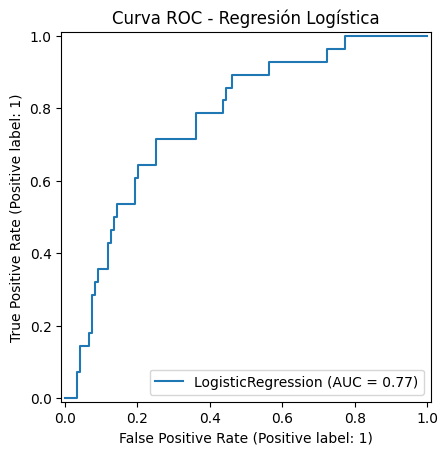

In [119]:
#Variables predictoras y objetivo
X_aki = df_aki.drop("lra", axis=1)
y_aki = df_aki["lra"]

#Dividir en entrenamiento y prueba
X_train_aki, X_test_aki, y_train_aki, y_test_aki = train_test_split(
    X_aki, y_aki, test_size=0.3, random_state=42, stratify=y_aki
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_aki = scaler.fit_transform(X_train_aki)
X_test_scaled_aki = scaler.transform(X_test_aki)

#Entrenar Modelo
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled_aki, y_train_aki)

#Evaluar Modelo
y_pred_aki = logreg.predict(X_test_scaled_aki)
y_prob_aki = logreg.predict_proba(X_test_scaled_aki)[:, 1]

print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_aki, y_pred_aki))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_aki, y_pred_aki))
print("ROC-AUC:", roc_auc_score(y_test_aki, y_prob_aki))

# Curva ROC
RocCurveDisplay.from_estimator(logreg, X_test_scaled_aki, y_test_aki)
plt.title("Curva ROC - Regresión Logística")
plt.show()

####Regresión df_mimic

MATRIZ DE CONFUSIÓN:
[[113  34]
 [ 90  84]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       147
           1       0.71      0.48      0.58       174

    accuracy                           0.61       321
   macro avg       0.63      0.63      0.61       321
weighted avg       0.64      0.61      0.61       321

ROC-AUC: 0.6693447493940106


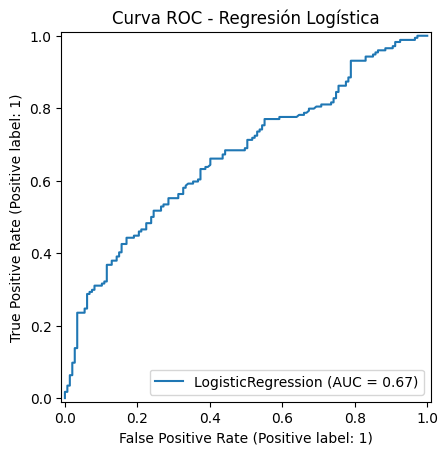

In [120]:
#Variables predictoras y objetivo
X_mimic = df_mimic.drop("lra", axis=1)
y_mimic = df_mimic["lra"]

#Dividir en entrenamiento y prueba
X_train_mimic, X_test_mimic, y_train_mimic, y_test_mimic = train_test_split(
    X_mimic, y_mimic, test_size=0.3, random_state=42, stratify=y_mimic
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_mimic = scaler.fit_transform(X_train_mimic)
X_test_scaled_mimic = scaler.transform(X_test_mimic)

#Entrenar Modelo
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled_mimic, y_train_mimic)

#Evaluar Modelo
y_pred = logreg.predict(X_test_scaled_mimic)
y_prob = logreg.predict_proba(X_test_scaled_mimic)[:, 1]

print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_mimic, y_pred))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_mimic, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_mimic, y_prob))

# Curva ROC
RocCurveDisplay.from_estimator(logreg, X_test_scaled_mimic, y_test_mimic)
plt.title("Curva ROC - Regresión Logística")
plt.show()

####Regresión df_udaki

MATRIZ DE CONFUSIÓN:
[[172  94]
 [ 90 112]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       266
           1       0.54      0.55      0.55       202

    accuracy                           0.61       468
   macro avg       0.60      0.60      0.60       468
weighted avg       0.61      0.61      0.61       468

ROC-AUC: 0.6752028586317278


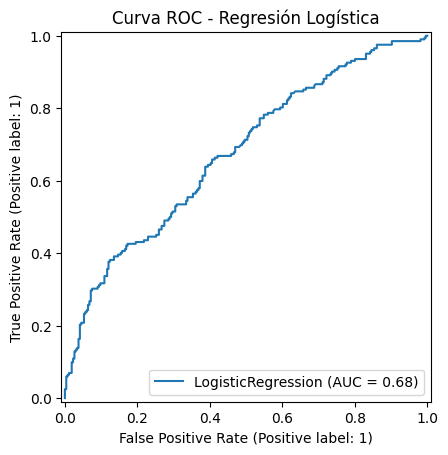

In [121]:
#Variables predictoras y objetivo
X_udaki = df_udaki.drop("lra", axis=1)
y_udaki= df_udaki["lra"]

#Dividir en entrenamiento y prueba
X_train_udaki, X_test_udaki, y_train_udaki, y_test_udaki = train_test_split(
    X_udaki, y_udaki, test_size=0.3, random_state=42, stratify=y_udaki
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_udaki = scaler.fit_transform(X_train_udaki)
X_test_scaled_udaki = scaler.transform(X_test_udaki)

#Entrenar Modelo
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled_udaki, y_train_udaki)

#Evaluar Modelo
y_pred = logreg.predict(X_test_scaled_udaki)
y_prob = logreg.predict_proba(X_test_scaled_udaki)[:, 1]

print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_udaki, y_pred))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_udaki, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_udaki, y_prob))

# Curva ROC
RocCurveDisplay.from_estimator(logreg, X_test_scaled_udaki, y_test_udaki)
plt.title("Curva ROC - Regresión Logística")
plt.show()

###Gradient Boosting

Los árboles potenciados utilizan modelos aditivos y algoritmos de avance gradual para implementar el proceso de optimización del aprendizaje.

####GB df_aki

MATRIZ DE CONFUSIÓN:
[[110   9]
 [ 21   7]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       119
           1       0.44      0.25      0.32        28

    accuracy                           0.80       147
   macro avg       0.64      0.59      0.60       147
weighted avg       0.76      0.80      0.77       147

 ROC-AUC: 0.6114945978391357


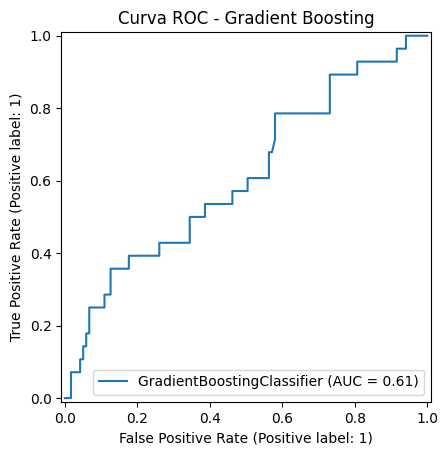


 Importancia de las variables:
                    Variable  Importancia
6           creatinina_basal     0.433462
0                       edad     0.193833
10         prioridad_urgente     0.089031
7                     sepsis     0.087436
8       choque_hipovolemico_     0.041839
5   enfermedad_renal_cronica     0.035753
2                        hta     0.031961
4                        asa     0.026575
1                         dm     0.023353
3                       ieca     0.021399
9           cirugia_vascular     0.015359


/tmp/ipython-input-626359954.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")


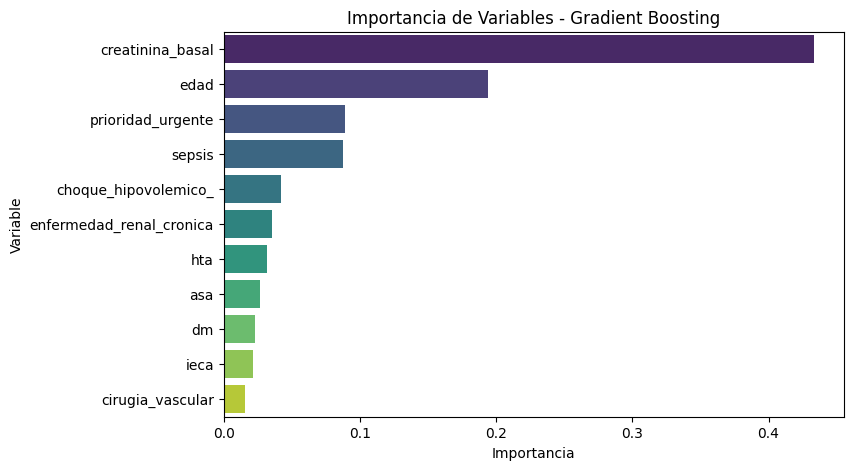

In [122]:
# Modelo Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=200,      # número de árboles
    learning_rate=0.05,    # velocidad de aprendizaje
    max_depth=3,           # profundidad de los árboles base
    random_state=42
)

gb.fit(X_train_scaled_aki, y_train_aki)

# Predicciones
y_pred = gb.predict(X_test_scaled_aki)
y_prob = gb.predict_proba(X_test_scaled_aki)[:, 1]

# Evaluación
print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_aki, y_pred))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_aki, y_pred))
print(" ROC-AUC:", roc_auc_score(y_test_aki, y_prob))

# Curva ROC
RocCurveDisplay.from_estimator(gb, X_test_scaled_aki, y_test_aki)
plt.title("Curva ROC - Gradient Boosting")
plt.show()

# Importancia de las variables
importances = gb.feature_importances_
features = X_aki.columns
imp_df = pd.DataFrame({"Variable": features, "Importancia": importances})
imp_df = imp_df.sort_values(by="Importancia", ascending=False)

print("\n Importancia de las variables:")
print(imp_df)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables - Gradient Boosting")
plt.show()

####GB df_mimic

MATRIZ DE CONFUSIÓN:
[[90 57]
 [77 97]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57       147
           1       0.63      0.56      0.59       174

    accuracy                           0.58       321
   macro avg       0.58      0.58      0.58       321
weighted avg       0.59      0.58      0.58       321

 ROC-AUC: 0.647138165611072


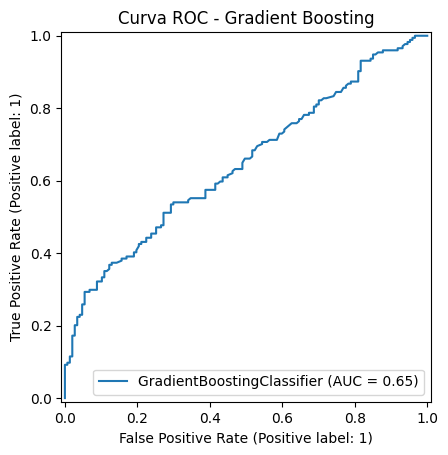


 Importancia de las variables:
                   Variable  Importancia
8          creatinina_basal     0.455470
0                      edad     0.321458
7                       asa     0.093588
3  enfermedad_renal_cronica     0.043332
1                        dm     0.039845
5      choque_hipovolemico_     0.018534
6                      ieca     0.014042
2                       hta     0.013730
4                    sepsis     0.000000


/tmp/ipython-input-405846330.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")


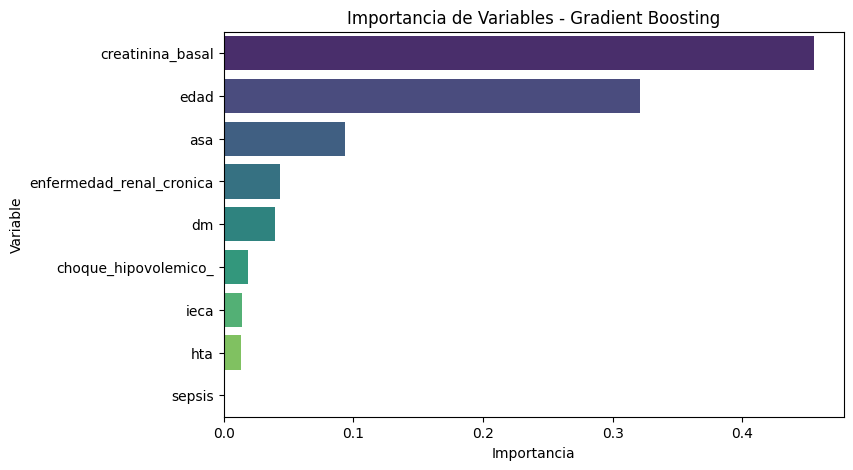

In [123]:
# Modelo Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=200,      # número de árboles
    learning_rate=0.05,    # velocidad de aprendizaje
    max_depth=3,           # profundidad de los árboles base
    random_state=42
)

gb.fit(X_train_scaled_mimic, y_train_mimic)

# Predicciones
y_pred = gb.predict(X_test_scaled_mimic)
y_prob = gb.predict_proba(X_test_scaled_mimic)[:, 1]

# Evaluación
print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_mimic, y_pred))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_mimic, y_pred))
print(" ROC-AUC:", roc_auc_score(y_test_mimic, y_prob))

# Curva ROC
RocCurveDisplay.from_estimator(gb, X_test_scaled_mimic, y_test_mimic)
plt.title("Curva ROC - Gradient Boosting")
plt.show()

# Importancia de las variables
importances = gb.feature_importances_
features = X_mimic.columns
imp_df = pd.DataFrame({"Variable": features, "Importancia": importances})
imp_df = imp_df.sort_values(by="Importancia", ascending=False)

print("\n Importancia de las variables:")
print(imp_df)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables - Gradient Boosting")
plt.show()

####GB df_udaki

MATRIZ DE CONFUSIÓN:
[[205  61]
 [ 87 115]]

 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       266
           1       0.65      0.57      0.61       202

    accuracy                           0.68       468
   macro avg       0.68      0.67      0.67       468
weighted avg       0.68      0.68      0.68       468

 ROC-AUC: 0.6994993672299561


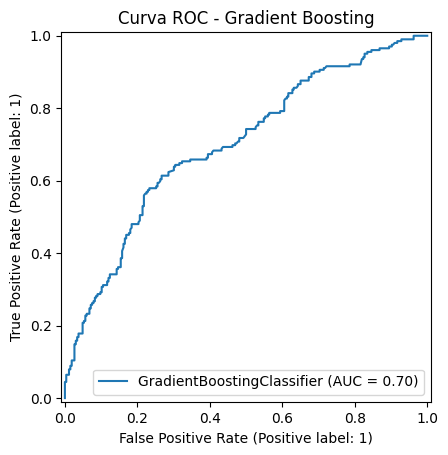


 Importancia de las variables:
                    Variable  Importancia
6           creatinina_basal     0.475480
0                       edad     0.222232
5   enfermedad_renal_cronica     0.117389
10         prioridad_urgente     0.051718
1                         dm     0.035956
4                        asa     0.031702
8       choque_hipovolemico_     0.023730
2                        hta     0.015642
7                     sepsis     0.012544
3                       ieca     0.009869
9           cirugia_vascular     0.003739


/tmp/ipython-input-3951710357.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")


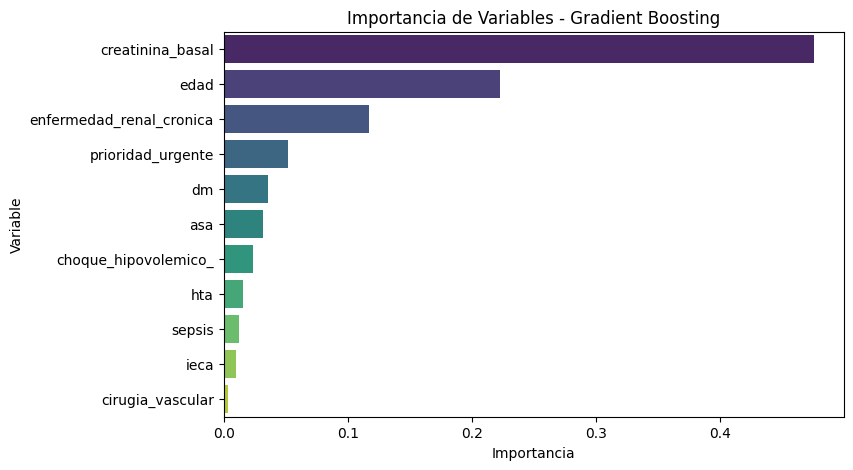

In [124]:
# Modelo Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=200,      # número de árboles
    learning_rate=0.05,    # velocidad de aprendizaje
    max_depth=3,           # profundidad de los árboles base
    random_state=42
)

gb.fit(X_train_scaled_udaki, y_train_udaki)

# Predicciones
y_pred = gb.predict(X_test_scaled_udaki)
y_prob = gb.predict_proba(X_test_scaled_udaki)[:, 1]

# Evaluación
print("MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_udaki, y_pred))
print("\n REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_udaki, y_pred))
print(" ROC-AUC:", roc_auc_score(y_test_udaki, y_prob))

# Curva ROC
RocCurveDisplay.from_estimator(gb, X_test_scaled_udaki, y_test_udaki)
plt.title("Curva ROC - Gradient Boosting")
plt.show()

# Importancia de las variables
importances = gb.feature_importances_
features = X_udaki.columns
imp_df = pd.DataFrame({"Variable": features, "Importancia": importances})
imp_df = imp_df.sort_values(by="Importancia", ascending=False)

print("\n Importancia de las variables:")
print(imp_df)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables - Gradient Boosting")
plt.show()

###Random Forest

Método de aprendizaje integrado que contiene múltiples árboles de decisión para la clasificación.

####RF df_aki

===== MÉTRICAS RANDOM FOREST =====
Accuracy: 0.748
ROC-AUC:  0.695

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       119
           1       0.30      0.25      0.27        28

    accuracy                           0.75       147
   macro avg       0.57      0.56      0.56       147
weighted avg       0.73      0.75      0.74       147



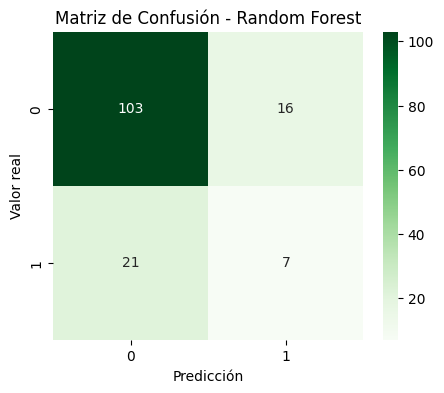

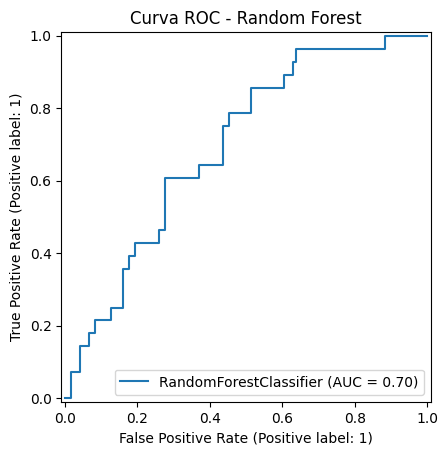

/tmp/ipython-input-17341025.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')


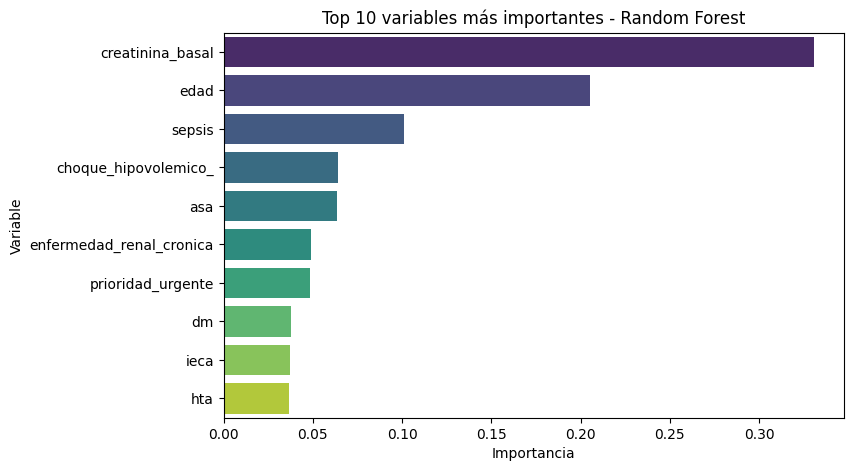

,Variable,Importancia
6,creatinina_basal,0.330861
0,edad,0.205404
7,sepsis,0.101004
8,choque_hipovolemico_,0.063799
4,asa,0.063329
5,enfermedad_renal_cronica,0.048818
10,prioridad_urgente,0.048286
1,dm,0.037582
3,ieca,0.037184
2,hta,0.036418


In [125]:
#Entrenamiento del modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight='balanced',   # útil para el desbalance 0/1
    n_jobs=-1
)
rf.fit(X_train_scaled_aki, y_train_aki)

#Predicciones
y_pred = rf.predict(X_test_scaled_aki)
y_prob = rf.predict_proba(X_test_scaled_aki)[:, 1]

#Métricas
print("===== MÉTRICAS RANDOM FOREST =====")
print(f"Accuracy: {rf.score(X_test_scaled_aki, y_test_aki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_aki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_aki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_aki, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(rf, X_test_scaled_aki, y_test_aki)
plt.title('Curva ROC - Random Forest')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_aki.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')
plt.title('Top 10 variables más importantes - Random Forest')
plt.show()

importancias.head(10)

####RF df_mimic

===== MÉTRICAS RANDOM FOREST =====
Accuracy: 0.611
ROC-AUC:  0.671

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       147
           1       0.68      0.54      0.60       174

    accuracy                           0.61       321
   macro avg       0.62      0.62      0.61       321
weighted avg       0.62      0.61      0.61       321



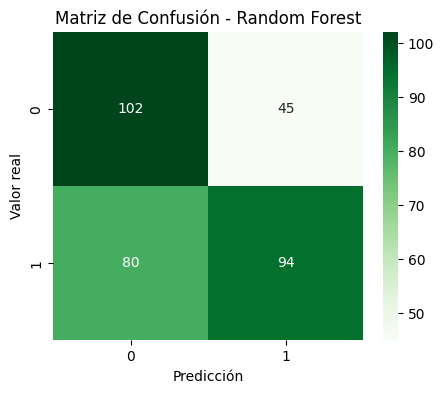

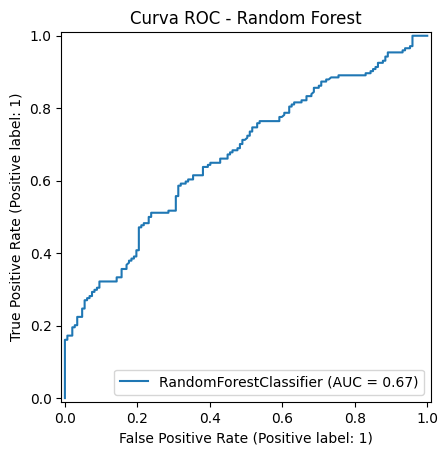

/tmp/ipython-input-1104421131.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')


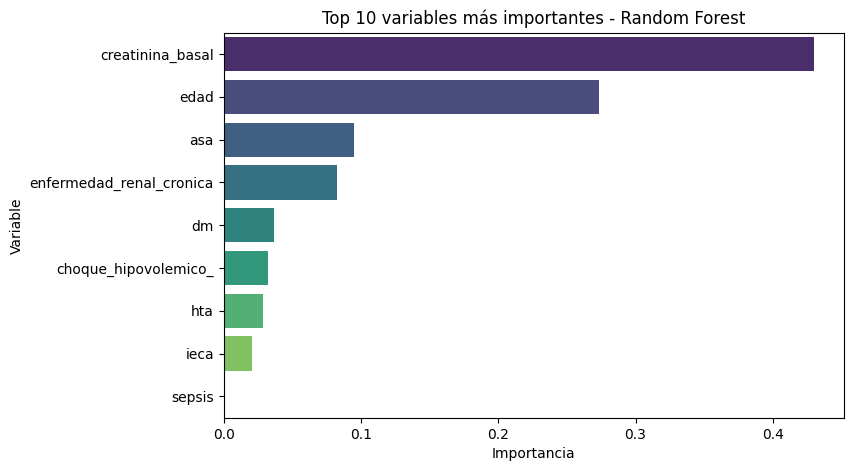

,Variable,Importancia
8,creatinina_basal,0.430098
0,edad,0.273514
7,asa,0.094726
3,enfermedad_renal_cronica,0.082843
1,dm,0.036749
5,choque_hipovolemico_,0.032318
2,hta,0.028955
6,ieca,0.020797
4,sepsis,0.000000


In [126]:
#Entrenamiento del modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight='balanced',   # útil para el desbalance 0/1
    n_jobs=-1
)
rf.fit(X_train_scaled_mimic, y_train_mimic)

#Predicciones
y_pred = rf.predict(X_test_scaled_mimic)
y_prob = rf.predict_proba(X_test_scaled_mimic)[:, 1]

#Métricas
print("===== MÉTRICAS RANDOM FOREST =====")
print(f"Accuracy: {rf.score(X_test_scaled_mimic, y_test_mimic):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_mimic, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_mimic, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_mimic, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(rf, X_test_scaled_mimic, y_test_mimic)
plt.title('Curva ROC - Random Forest')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_mimic.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')
plt.title('Top 10 variables más importantes - Random Forest')
plt.show()

importancias.head(10)

####RF df_udaki

===== MÉTRICAS RANDOM FOREST =====
Accuracy: 0.645
ROC-AUC:  0.697

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       266
           1       0.59      0.58      0.58       202

    accuracy                           0.65       468
   macro avg       0.64      0.64      0.64       468
weighted avg       0.64      0.65      0.64       468



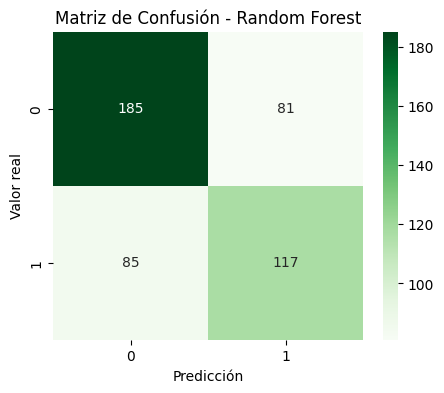

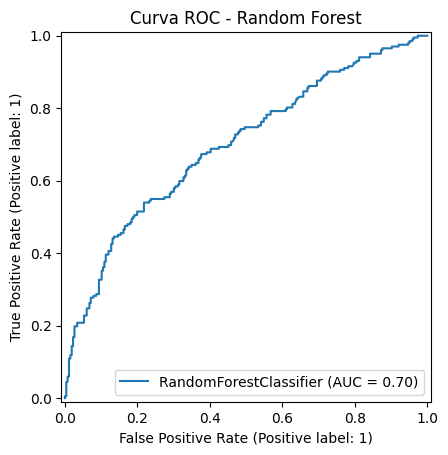

/tmp/ipython-input-574240912.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')


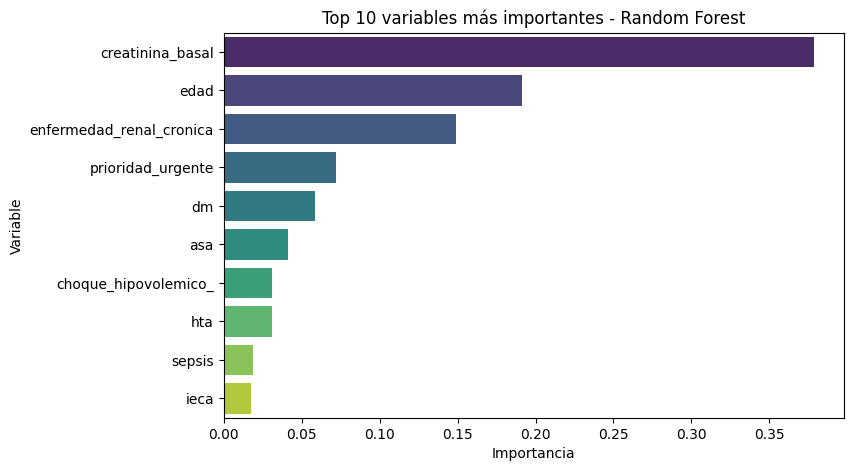

,Variable,Importancia
6,creatinina_basal,0.378661
0,edad,0.191287
5,enfermedad_renal_cronica,0.149274
10,prioridad_urgente,0.072128
1,dm,0.058631
4,asa,0.041076
8,choque_hipovolemico_,0.030969
2,hta,0.030778
7,sepsis,0.018983
3,ieca,0.017728


In [127]:
#Entrenamiento del modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight='balanced',   # útil para el desbalance 0/1
    n_jobs=-1
)
rf.fit(X_train_scaled_udaki, y_train_udaki)

#Predicciones
y_pred = rf.predict(X_test_scaled_udaki)
y_prob = rf.predict_proba(X_test_scaled_udaki)[:, 1]

#Métricas
print("===== MÉTRICAS RANDOM FOREST =====")
print(f"Accuracy: {rf.score(X_test_scaled_udaki, y_test_udaki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_udaki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_udaki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_udaki, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(rf, X_test_scaled_udaki, y_test_udaki)
plt.title('Curva ROC - Random Forest')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_udaki.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='viridis')
plt.title('Top 10 variables más importantes - Random Forest')
plt.show()

importancias.head(10)

###XGBoost
El aumento de gradiente extremo (XGBoost) también es un tipo de algoritmo de integración, como un modelo de árbol reforzado, que consiste en una combinación de varios modelos de árbol para formar un clasificador muy robusto. Además, el modelo de árbol utilizado es el modelo de árbol de regresión CART.

####XG df_aki

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.782
ROC-AUC:  0.685

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       119
           1       0.38      0.21      0.27        28

    accuracy                           0.78       147
   macro avg       0.60      0.57      0.57       147
weighted avg       0.75      0.78      0.76       147



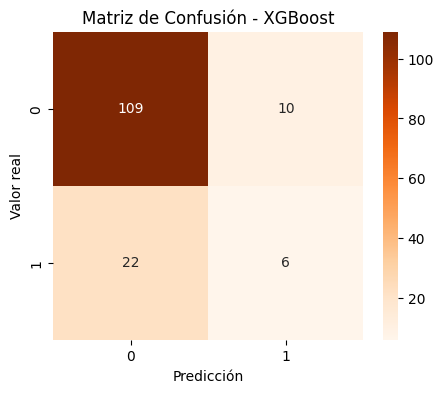

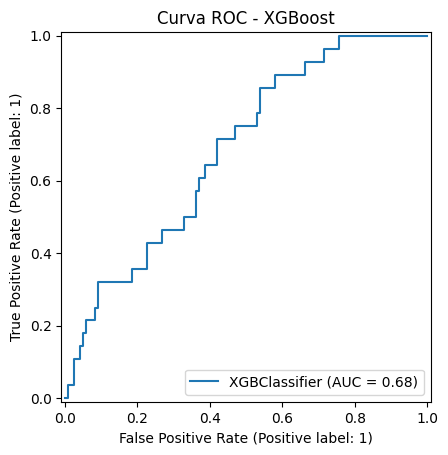

/tmp/ipython-input-3378236271.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


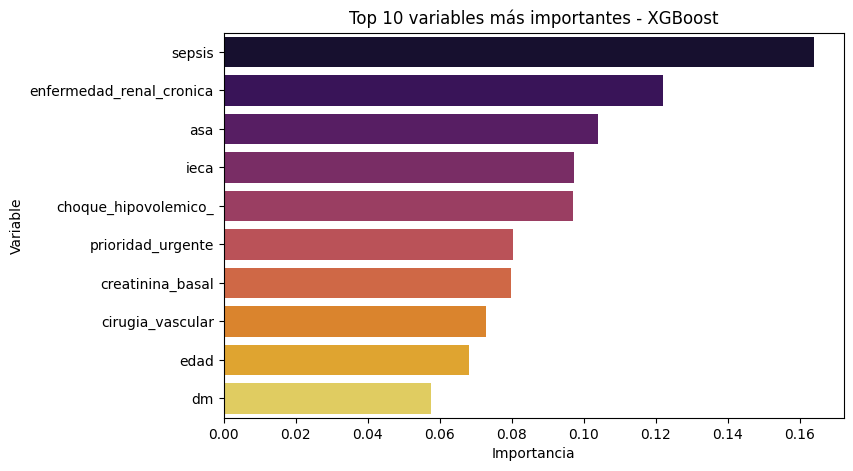

,Variable,Importancia
7,sepsis,0.163982
5,enfermedad_renal_cronica,0.121975
4,asa,0.104017
3,ieca,0.097416
8,choque_hipovolemico_,0.097052
10,prioridad_urgente,0.080257
6,creatinina_basal,0.079745
9,cirugia_vascular,0.072735
0,edad,0.068235
1,dm,0.057464


In [128]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_aki, y_train_aki)

#Predicciones
y_pred = xgb.predict(X_test_scaled_aki)
y_prob = xgb.predict_proba(X_test_scaled_aki)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_aki, y_test_aki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_aki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_aki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_aki, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_aki, y_test_aki)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_aki.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

####XG df_mimic

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.632
ROC-AUC:  0.665

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       147
           1       0.68      0.62      0.65       174

    accuracy                           0.63       321
   macro avg       0.63      0.63      0.63       321
weighted avg       0.64      0.63      0.63       321



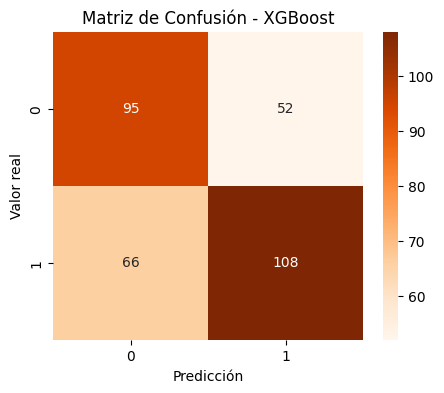

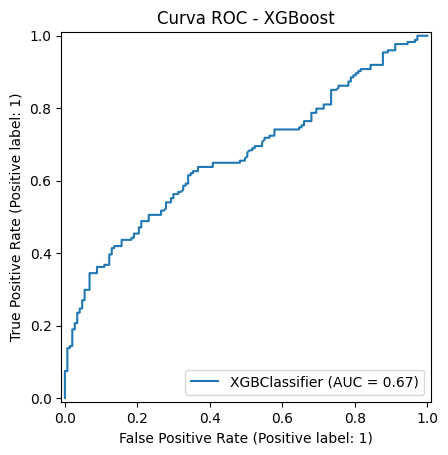

/tmp/ipython-input-3521076292.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


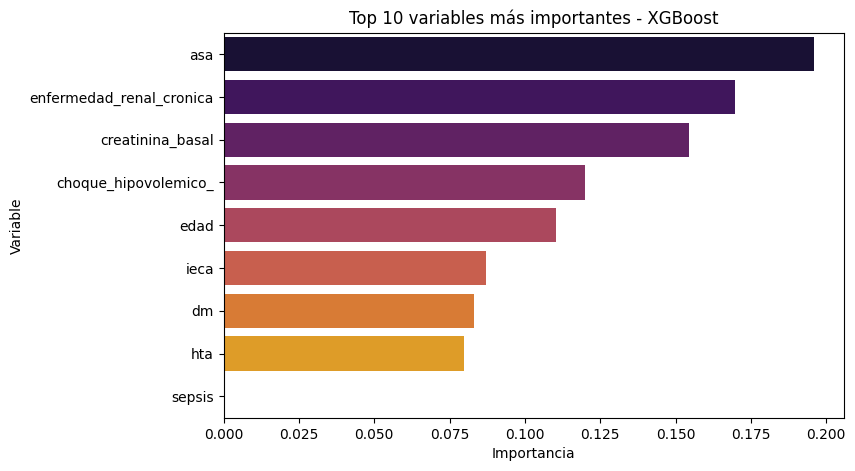

,Variable,Importancia
7,asa,0.195992
3,enfermedad_renal_cronica,0.169710
8,creatinina_basal,0.154316
5,choque_hipovolemico_,0.119957
0,edad,0.110263
6,ieca,0.087087
1,dm,0.083027
2,hta,0.079649
4,sepsis,0.000000


In [129]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_mimic, y_train_mimic)

#Predicciones
y_pred = xgb.predict(X_test_scaled_mimic)
y_prob = xgb.predict_proba(X_test_scaled_mimic)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_mimic, y_test_mimic):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_mimic, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_mimic, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_mimic, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_mimic, y_test_mimic)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_mimic.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

####XG df_udaki

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:11:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.654
ROC-AUC:  0.686

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       266
           1       0.62      0.52      0.57       202

    accuracy                           0.65       468
   macro avg       0.65      0.64      0.64       468
weighted avg       0.65      0.65      0.65       468



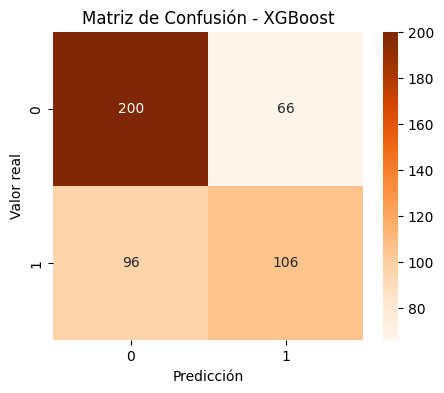

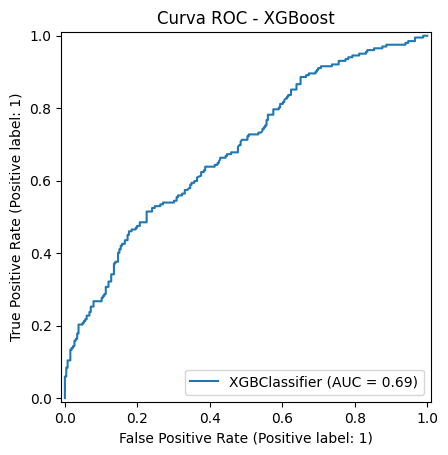

/tmp/ipython-input-1656711334.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


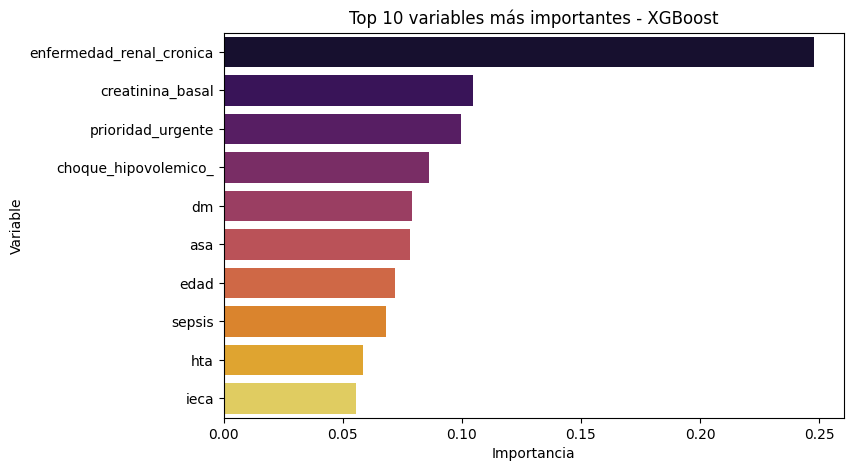

,Variable,Importancia
5,enfermedad_renal_cronica,0.247867
6,creatinina_basal,0.104591
10,prioridad_urgente,0.099423
8,choque_hipovolemico_,0.086385
1,dm,0.079085
4,asa,0.078156
0,edad,0.072050
7,sepsis,0.068340
2,hta,0.058446
3,ieca,0.055497


In [130]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_udaki, y_train_udaki)

#Predicciones
y_pred = xgb.predict(X_test_scaled_udaki)
y_prob = xgb.predict_proba(X_test_scaled_udaki)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_udaki, y_test_udaki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_udaki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_udaki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_udaki, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_udaki, y_test_udaki)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_udaki.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

### Modelo de Red Neuronal
Red neuronal artificial de propagación hacia adelante con al menos tres capas: una capa de entrada, una o más capas ocultas y una capa de salida. Funciona procesando datos a través de estas capas, donde cada neurona realiza una suma ponderada de sus entradas y la pasa por una función de activación para generar una salida que se pasa a la siguiente capa.

Para este caso se decidió utilizar la red neuronal solamente con el conjunto de datos udaki, esto debido a que es el conjunto con el mayor número de datos.

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_improved_model(input_dim):
    model = Sequential()

    # Capa de entrada con más neuronas
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Capas ocultas
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Optimizador con learning rate ajustado
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', 'precision', 'recall'])

    return model

# Usar el modelo mejorado
improved_model = create_improved_model(X_train_udaki.shape[1])
improved_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 192 (768.00 B)

In [132]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10)
]

history = improved_model.fit(
    X_train_udaki, y_train_udaki,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5657 - loss: 0.9717 - precision: 0.5070 - recall: 0.2790 - val_accuracy: 0.5642 - val_loss: 0.8718 - val_precision: 0.5000 - val_recall: 0.0316 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5647 - loss: 0.8434 - precision: 0.4871 - recall: 0.2850 - val_accuracy: 0.4495 - val_loss: 0.7687 - val_precision: 0.4419 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5272 - loss: 0.8333 - precision: 0.4333 - recall: 0.3324 - val_accuracy: 0.4725 - val_loss: 0.7420 - val_precision: 0.4510 - val_recall: 0.9684 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5809 - loss: 0.7940 - precision: 0.4984 - recall: 0.4374 - val_accuracy: 0.5092 - val_loss: 0.7449 - val_precision: 0.4688 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.55

In [133]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Obtener predicciones binarias
y_pred_prob = improved_model.predict(X_test_udaki)
y_pred = (y_pred_prob > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test_udaki, y_pred)
print("Matriz de Confusión:")
print(cm)

# Métricas detalladas
print("\nReporte de Clasificación:")
print(classification_report(y_test_udaki, y_pred, digits=4))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Matriz de Confusión:
[[225  41]
 [116  86]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.6598    0.8459    0.7414       266
           1     0.6772    0.4257    0.5228       202

    accuracy                         0.6645       468
   macro avg     0.6685    0.6358    0.6321       468
weighted avg     0.6673    0.6645    0.6470       468



In [134]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

def evaluate_model_clinically(model, X_test_udaki, y_test_udaki):
    # Predicciones
    y_pred_proba = model.predict(X_test_udaki)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Métricas básicas
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_udaki, y_test_udaki, verbose=0)


    # Métricas específicas para problemas médicos
    print("=== EVALUACIÓN CLÍNICA DEL MODELO ===")
    print(f"Pérdida: {test_loss:.4f}")
    print(f"Precisión: {test_accuracy:.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test_udaki, y_pred_proba):.4f}")
    print("\n=== MATRIZ DE CONFUSIÓN ===")
    cm = confusion_matrix(y_test_udaki, y_pred)
    print(cm)
    print("\n=== REPORTE DE CLASIFICACIÓN ===")
    print(classification_report(y_test_udaki, y_pred, target_names=['No LRA', 'LRA']))

    # Métricas específicas para diagnóstico médico
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall para clase positiva
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Recall para clase negativa
    precision_lra = tp / (tp + fp) if (tp + fp) > 0 else 0

    print(f"Sensibilidad (Recall LRA): {sensitivity:.4f}")
    print(f"Especificidad (Recall No LRA): {specificity:.4f}")
    print(f"Precisión para LRA: {precision_lra:.4f}")

# Usar la evaluación mejorada
evaluate_model_clinically(improved_model, X_test_udaki, y_test_udaki)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
=== EVALUACIÓN CLÍNICA DEL MODELO ===
Pérdida: 0.6579
Precisión: 0.6645
AUC-ROC: 0.6842

=== MATRIZ DE CONFUSIÓN ===
[[225  41]
 [116  86]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

      No LRA       0.66      0.85      0.74       266
         LRA       0.68      0.43      0.52       202

    accuracy                           0.66       468
   macro avg       0.67      0.64      0.63       468
weighted avg       0.67      0.66      0.65       468

Sensibilidad (Recall LRA): 0.4257
Especificidad (Recall No LRA): 0.8459
Precisión para LRA: 0.6772


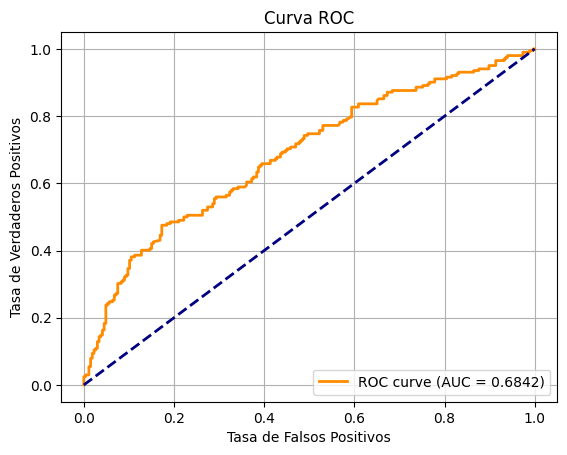

In [135]:
from sklearn.metrics import roc_curve, auc
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_udaki, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Gráfico
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

###GB Optimizado con hiperparámetros

Debido a la búsqueda de mejores modelos, se encontró el modelo a continuación, que acompañado de hiperparámetros logra buenos resultados en recall que es una métrica de interés. Por esto se incluye en este apartado.

In [136]:
# Configuración reproducible
np.random.seed(42)

# Cargar datos
X = df_udaki.drop('lra', axis=1)
y = df_udaki['lra']

# 1. Dividir datos manteniendo proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 2. Crear pipeline mejorado con manejo de desbalanceo
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Manejar valores missing
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Balancear clases
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 3. Espacio de hiperparámetros más inteligente y amplio
param_dist = {
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [2, 3, 4, 5, 6],
    'gb__min_samples_split': [2, 5, 10, 15],
    'gb__min_samples_leaf': [1, 2, 3, 4],
    'gb__subsample': [0.7, 0.8, 0.9, 1.0],
    'gb__max_features': ['sqrt', 'log2', None, 0.8, 0.9],
    'gb__loss': ['log_loss', 'exponential']
}

# 4. Múltiples métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': 'f1_macro'
}

# 5. Configurar búsqueda más robusta con validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar RandomizedSearchCV para mayor eficiencia con espacio de búsqueda amplio
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones a probar
    scoring=scoring,
    refit='f1',  # Reentrenar con F1 para clase positiva
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 6. Resultados detallados
print("\n" + "="*60)
print("MEJORES RESULTADOS OBTENIDOS")
print("="*60)

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntaje F1 (validación): {random_search.best_score_:.4f}")

# 7. Evaluación comprehensiva en test
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*60)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

# 8. Análisis de diferentes umbrales
print("\n" + "="*60)
print("ANÁLISIS DE UMBRALES ALTERNATIVOS")
print("="*60)

# Probar diferentes umbrales para optimizar recall o precision
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_custom, pos_label=1)
    current_recall = recall_score(y_test, y_pred_custom, pos_label=1)
    current_precision = precision_score(y_test, y_pred_custom, pos_label=1)

    print(f"Umbral {threshold}: F1={current_f1:.4f}, Recall={current_recall:.4f}, Precision={current_precision:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nMejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

# 9. Resultados con el mejor umbral
print(f"\nRESULTADOS CON UMBRAL OPTIMIZADO ({best_threshold}):")
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")

print("\nMatriz de Confusión Optimizada:")
print(confusion_matrix(y_test, y_pred_optimized))

# 10. Comparación con modelo base (sin optimizar)
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Aplica imputación a X_train y X_test antes de entrenar modelo base
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_model = GBC(random_state=42)
base_model.fit(X_train_imputed, y_train)
y_pred_base = base_model.predict(X_test_imputed)

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO BASE (SIN OPTIMIZAR)")
print("="*60)

print(f"Modelo Base - F1: {f1_score(y_test, y_pred_base, pos_label=1):.4f}")
print(f"Modelo Optimizado - F1: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Mejora: {f1_score(y_test, y_pred_optimized, pos_label=1) - f1_score(y_test, y_pred_base, pos_label=1):.4f}")

# 11. Feature importance del mejor modelo
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (Top 10)")
print("="*60)

feature_importances = random_search.best_estimator_.named_steps['gb'].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

Distribución de clases en entrenamiento: [707 539]
Distribución de clases en test: [177 135]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

MEJORES RESULTADOS OBTENIDOS
Mejores hiperparámetros: {'gb__subsample': 1.0, 'gb__n_estimators': 400, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 2, 'gb__max_features': 'sqrt', 'gb__max_depth': 6, 'gb__loss': 'exponential', 'gb__learning_rate': 0.01}
Mejor puntaje F1 (validación): 0.6006

EVALUACIÓN EN CONJUNTO DE TEST
Accuracy: 0.6442
Precision: 0.5882
Recall: 0.5926
F1 Score: 0.5904

Matriz de Confusión:
[[121  56]
 [ 55  80]]

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       177
           1       0.59      0.59      0.59       135

    accuracy                           0.64       312
   macro avg       0.64      0.64      0.64       312
weighted avg       0.64      0.64      0.64       3

### Técnicas de Aumento de datos

Como los dos principales problemas que se enfrentan con el tema de los datos en esta investigación son el desbalanceo de la clase objetivo y la escasez de datos para brindarle a los modelos, se exploraron diferentes alternativas para el manejo de esta situación.

####SMOTE

SMOTE(Synthetic Minority Over-sampling Technique) es una técnica que sirve para conjuntos de datos que tienen desbalance, lo que hace es crear datos sintéticos para hacer un sobremuestreo de la clase minoritaria. En nuestro caso nos ayudaría a generar datos sinteticos de pacientes con LRA.

In [137]:
#Se copia el conjunto de datos udaki que tiene más datos.
df_udaki_smote = df_udaki.copy()

In [138]:
#Se comprueba que tenga la misma información que udaki original
df_udaki_smote.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 0 to 1068
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1558 non-null   int64  
 1   dm                        1558 non-null   int64  
 2   hta                       1558 non-null   int64  
 3   ieca                      1558 non-null   int64  
 4   asa                       1558 non-null   int64  
 5   enfermedad_renal_cronica  1558 non-null   int64  
 6   creatinina_basal          1558 non-null   float64
 7   sepsis                    1558 non-null   int64  
 8   choque_hipovolemico_      1558 non-null   int64  
 9   cirugia_vascular          1558 non-null   int64  
 10  prioridad_urgente         1558 non-null   int64  
 11  lra                       1558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 158.2 KB


APLICACIÓN DE SMOTE EN DF_UDAKI
Distribución original - Entrenamiento: [707 539]
Distribución original - Test: [177 135]
Distribución después de SMOTE - Entrenamiento: [707 707]
Búsqueda del mejor umbral
Umbral 0.2: F1=0.6106
Umbral 0.3: F1=0.6186
Umbral 0.4: F1=0.6087
Umbral 0.5: F1=0.5804
Umbral 0.6: F1=0.5182
Mejor umbral encontrado: 0.3 (F1=0.6186)
Resultados finales con SMOTE
Accuracy:  0.5256
Precision: 0.4743
Recall:    0.8889
F1-Score:  0.6186
Matriz de Confusión:
[[ 44 133]
 [ 15 120]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.75      0.25      0.37       177
           1       0.47      0.89      0.62       135

    accuracy                           0.53       312
   macro avg       0.61      0.57      0.50       312
weighted avg       0.63      0.53      0.48       312

Ejecución completada


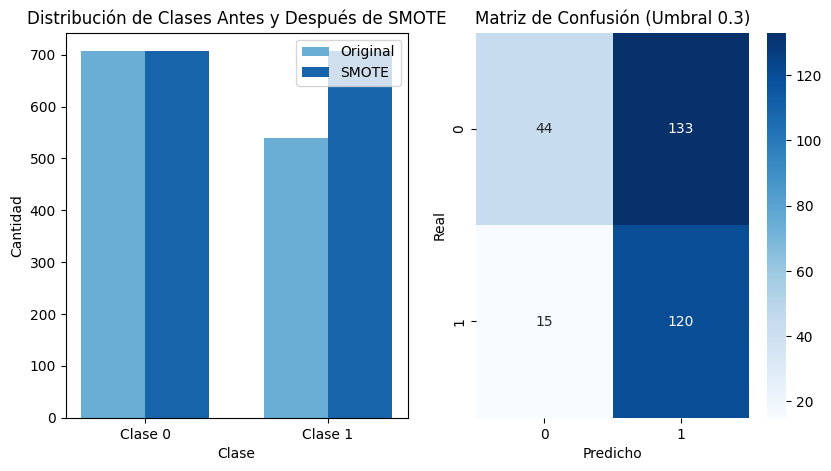

In [139]:
#SMOTE
from imblearn.over_sampling import SMOTE

def aplicar_smote_df_udaki(df, target_col='lra', test_size=0.2, random_state=42):

    # Separar características y variable objetivo
    X = df.drop(columns=[target_col])
    y = df[target_col]

    print("APLICACIÓN DE SMOTE EN DF_UDAKI")

    # División train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Distribución original - Entrenamiento: {np.bincount(y_train)}")
    print(f"Distribución original - Test: {np.bincount(y_test)}")

    # Aplicar SMOTE solo al entrenamiento
    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print(f"Distribución después de SMOTE - Entrenamiento: {np.bincount(y_train_smote)}")

    # Modelo GBM
    gb_model = GradientBoostingClassifier(
        subsample=0.8,
        n_estimators=400,
        min_samples_split=10,
        min_samples_leaf=3,
        max_features=0.9,
        max_depth=4,
        loss='exponential',
        learning_rate=0.01,
        random_state=random_state
    )

    gb_model.fit(X_train_smote, y_train_smote)

    # Predicciones
    y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

    # Búsqueda del mejor umbral
    best_threshold = 0.3
    best_f1 = 0

    print("Búsqueda del mejor umbral")

    for threshold in [0.2, 0.3, 0.4, 0.5, 0.6]:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)

        print(f"Umbral {threshold}: F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Mejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

    # Evaluación con el mejor umbral
    y_pred_best = (y_pred_proba >= best_threshold).astype(int)

    print("Resultados finales con SMOTE")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred_best):.4f}")

    cm = confusion_matrix(y_test, y_pred_best)
    print("Matriz de Confusión:")
    print(cm)

    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_best))

    # Gráficas
    plt.figure(figsize=(15, 5))

    # Gráfica 1: Distribución de clases en tonos azules
    plt.subplot(1, 3, 1)
    counts_original = [np.sum(y_train == 0), np.sum(y_train == 1)]
    counts_smote = [np.sum(y_train_smote == 0), np.sum(y_train_smote == 1)]

    x = np.arange(2)
    width = 0.35

    color_original = plt.cm.Blues(0.5)
    color_smote = plt.cm.Blues(0.8)

    plt.bar(x - width/2, counts_original, width, label='Original', color=color_original)
    plt.bar(x + width/2, counts_smote, width, label='SMOTE', color=color_smote)

    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.title('Distribución de Clases Antes y Después de SMOTE')
    plt.xticks(x, ['Clase 0', 'Clase 1'])
    plt.legend()

    # Gráfica 2: Matriz de confusión
    plt.subplot(1, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión (Umbral {best_threshold})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')

# Ejecución
if __name__ == "__main__":
    resultados = aplicar_smote_df_udaki(df_udaki)
    print("Ejecución completada")

####TVAE

TVAE (Tabular Variational Autoencoder). Variante de los autoencoders variacionales adaptada a tablas. Codificación probabilística: continuas como gaussianas, categóricas como distribuciones categóricas. Arquitectura encoder-decoder: mapea cada fila a un espacio latente y la reconstruye. Utilizamos un dataset que se construyó utilizando esta técnica y vamos a probar el conjunto de datos con un Gradient Boosting.


In [140]:
#Visualización de 5 pacientes y sus respectivas variables.
df_tvae = pd.read_excel('/content/Monografia/Conjuntos_de_datos/df_udaki_tvae (2).xlsx')
df_tvae.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


In [141]:
#Sacamos un info para observar el aumento de datos y que no hay nulos.
df_tvae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   int64  
 1   dm                        2558 non-null   int64  
 2   hta                       2558 non-null   int64  
 3   ieca                      2558 non-null   int64  
 4   asa                       2558 non-null   int64  
 5   enfermedad_renal_cronica  2558 non-null   int64  
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   int64  
 8   choque_hipovolemico_      2558 non-null   int64  
 9   cirugia_vascular          2558 non-null   int64  
 10  prioridad_urgente         2558 non-null   int64  
 11  lra                       2558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 239.9 KB


In [142]:
#Evidencia del balance en la clase a predecir.
print(df_tvae['lra'].value_counts())

lra
0    1480
1    1078
Name: count, dtype: int64


In [143]:
# Configuración reproducible (semilla)
np.random.seed(42)

# Cargar datos
X = df_tvae.drop('lra', axis=1)
y = df_tvae['lra']

# Ensure the target variable 'lra' is of a consistent type (integer)
y = pd.to_numeric(y, errors='coerce').astype(int)


# 1. Dividir datos manteniendo proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 2. Crear pipeline mejorado con manejo de desbalanceo
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Manejar valores missing
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Balancear clases
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 3. Espacio de hiperparámetros más inteligente y amplio
param_dist = {
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [2, 3, 4, 5, 6],
    'gb__min_samples_split': [2, 5, 10, 15],
    'gb__min_samples_leaf': [1, 2, 3, 4],
    'gb__subsample': [0.7, 0.8, 0.9, 1.0],
    'gb__max_features': ['sqrt', 'log2', None, 0.8, 0.9],
    'gb__loss': ['log_loss', 'exponential']
}

# 4. Múltiples métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': 'f1_macro'
}

# 5. Configurar búsqueda más robusta con validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar RandomizedSearchCV para mayor eficiencia con espacio de búsqueda amplio
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones a probar
    scoring=scoring,
    refit='f1',  # Reentrenar con F1 para clase positiva
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 6. Resultados detallados
print("\n" + "="*60)
print("MEJORES RESULTADOS OBTENIDOS")
print("="*60)

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntaje F1 (validación): {random_search.best_score_:.4f}")

# 7. Evaluación comprehensiva en test
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*60)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

# 8. Análisis de diferentes umbrales
print("\n" + "="*60)
print("ANÁLISIS DE UMBRALES ALTERNATIVOS")
print("="*60)

# Probar diferentes umbrales para optimizar recall o precision
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_custom, pos_label=1)
    current_recall = recall_score(y_test, y_pred_custom, pos_label=1)
    current_precision = precision_score(y_test, y_pred_custom, pos_label=1)

    print(f"Umbral {threshold}: F1={current_f1:.4f}, Recall={current_recall:.4f}, Precision={current_precision:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nMejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

# 9. Resultados con el mejor umbral
print(f"\nRESULTADOS CON UMBRAL OPTIMIZADO ({best_threshold}):")
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")

print("\nMatriz de Confusión Optimizada:")
print(confusion_matrix(y_test, y_pred_optimized))

# 10. Comparación con modelo base (sin optimizar)
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Aplica imputación a X_train y X_test antes de entrenar modelo base
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_model = GBC(random_state=42)
base_model.fit(X_train_imputed, y_train)
y_pred_base = base_model.predict(X_test_imputed)

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO BASE (SIN OPTIMIZAR)")
print("="*60)

print(f"Modelo Base - F1: {f1_score(y_test, y_pred_base, pos_label=1):.4f}")
print(f"Modelo Optimizado - F1: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Mejora: {f1_score(y_test, y_pred_optimized, pos_label=1) - f1_score(y_test, y_pred_base, pos_label=1):.4f}")

# 11. Importancia de variables del mejor modelo
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (Top 10)")
print("="*60)

feature_importances = random_search.best_estimator_.named_steps['gb'].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

Distribución de clases en entrenamiento: [1184  862]
Distribución de clases en test: [296 216]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

MEJORES RESULTADOS OBTENIDOS
Mejores hiperparámetros: {'gb__subsample': 0.8, 'gb__n_estimators': 100, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 1, 'gb__max_features': 'sqrt', 'gb__max_depth': 4, 'gb__loss': 'log_loss', 'gb__learning_rate': 0.15}
Mejor puntaje F1 (validación): 0.5934

EVALUACIÓN EN CONJUNTO DE TEST
Accuracy: 0.6289
Precision: 0.5670
Recall: 0.5093
F1 Score: 0.5366

Matriz de Confusión:
[[212  84]
 [106 110]]

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       296
           1       0.57      0.51      0.54       216

    accuracy                           0.63       512
   macro avg       0.62      0.61      0.61       512
weighted avg       0.62      0.63      0.63       512

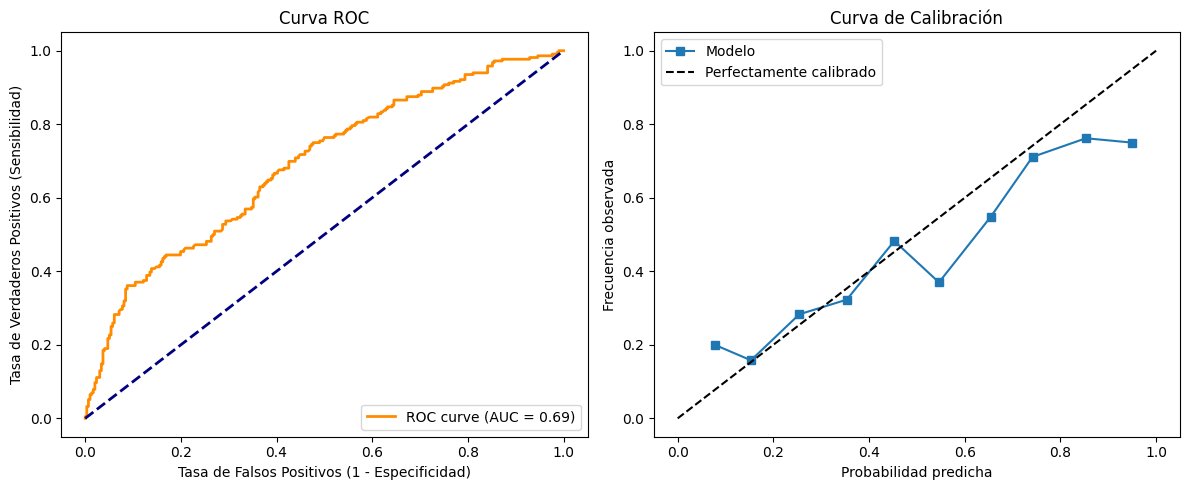

In [144]:
# Cargar el modelo entrenado
modelo = random_search.best_estimator_

# Obtener probabilidades predichas para la clase positiva (LRA=1)
y_proba = modelo.predict_proba(X_test)[:, 1]

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")

# 3. Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

plt.subplot(1,2,2)
plt.plot(prob_pred, prob_true, "s-", label="Modelo")
plt.plot([0, 1], [0, 1], "k--", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curva de Calibración")
plt.legend()

plt.tight_layout()
plt.show()

####CTGAN

CTGAN (Conditional Tabular GAN). Variante de las GANs adaptada a datos tabulares. Codificación: combina one-hot encoding para variables categóricas y normalización específica para continuas. Entrenamiento condicional: el generador recibe como condición la clase (ej. LRA=1) para forzar la creación de ejemplos sintéticos de esa categoría. Utilizamos un dataset que se construyó utilizando esta técnica y vamos a probar el conjunto de datos con un Gradient Boosting.

In [145]:
#Visualización de 5 pacientes y sus respectivas variables.
df_ctgan = pd.read_excel('/content/Monografia/Conjuntos_de_datos/df_udaki_ctgan (2).xlsx')
df_ctgan.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


In [146]:
#Sacamos un info para observar el aumento de datos y que no hay nulos.
df_ctgan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      2558 non-null   int64  
 1   dm                        2558 non-null   int64  
 2   hta                       2558 non-null   int64  
 3   ieca                      2558 non-null   int64  
 4   asa                       2558 non-null   int64  
 5   enfermedad_renal_cronica  2558 non-null   int64  
 6   creatinina_basal          2558 non-null   float64
 7   sepsis                    2558 non-null   int64  
 8   choque_hipovolemico_      2558 non-null   int64  
 9   cirugia_vascular          2558 non-null   int64  
 10  prioridad_urgente         2558 non-null   int64  
 11  lra                       2558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 239.9 KB


In [147]:
#Evidencia del balance en la clase a predecir.
print(df_tvae['lra'].value_counts())

lra
0    1480
1    1078
Name: count, dtype: int64


In [148]:
# Configuración reproducible
np.random.seed(42)

# Cargar datos
X = df_ctgan.drop('lra', axis=1)
y = df_ctgan['lra']

# Ensure the target variable 'lra' is of a consistent type (integer)
y = pd.to_numeric(y, errors='coerce').astype(int)


# 1. Dividir datos manteniendo proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 2. Crear pipeline mejorado con manejo de desbalanceo
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Manejar valores missing
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Balancear clases
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 3. Espacio de hiperparámetros más inteligente y amplio
param_dist = {
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'gb__max_depth': [2, 3, 4, 5, 6],
    'gb__min_samples_split': [2, 5, 10, 15],
    'gb__min_samples_leaf': [1, 2, 3, 4],
    'gb__subsample': [0.7, 0.8, 0.9, 1.0],
    'gb__max_features': ['sqrt', 'log2', None, 0.8, 0.9],
    'gb__loss': ['log_loss', 'exponential']
}

# 4. Múltiples métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': 'f1_macro'
}

# 5. Configurar búsqueda más robusta con validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar RandomizedSearchCV para mayor eficiencia con espacio de búsqueda amplio
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinaciones a probar
    scoring=scoring,
    refit='f1',  # Reentrenar con F1 para clase positiva
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# 6. Resultados detallados
print("\n" + "="*60)
print("MEJORES RESULTADOS OBTENIDOS")
print("="*60)

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntaje F1 (validación): {random_search.best_score_:.4f}")

# 7. Evaluación comprehensiva en test
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*60)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

# 8. Análisis de diferentes umbrales
print("\n" + "="*60)
print("ANÁLISIS DE UMBRALES ALTERNATIVOS")
print("="*60)

# Probar diferentes umbrales para optimizar recall o precision
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_custom, pos_label=1)
    current_recall = recall_score(y_test, y_pred_custom, pos_label=1)
    current_precision = precision_score(y_test, y_pred_custom, pos_label=1)

    print(f"Umbral {threshold}: F1={current_f1:.4f}, Recall={current_recall:.4f}, Precision={current_precision:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nMejor umbral encontrado: {best_threshold} (F1={best_f1:.4f})")

# 9. Resultados con el mejor umbral
print(f"\nRESULTADOS CON UMBRAL OPTIMIZADO ({best_threshold}):")
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")

print("\nMatriz de Confusión Optimizada:")
print(confusion_matrix(y_test, y_pred_optimized))

# 10. Comparación con modelo base (sin optimizar)
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Aplica imputación a X_train y X_test antes de entrenar modelo base
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_model = GBC(random_state=42)
base_model.fit(X_train_imputed, y_train)
y_pred_base = base_model.predict(X_test_imputed)

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO BASE (SIN OPTIMIZAR)")
print("="*60)

print(f"Modelo Base - F1: {f1_score(y_test, y_pred_base, pos_label=1):.4f}")
print(f"Modelo Optimizado - F1: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")
print(f"Mejora: {f1_score(y_test, y_pred_optimized, pos_label=1) - f1_score(y_test, y_pred_base, pos_label=1):.4f}")

# 11. Feature importance del mejor modelo
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (Top 10)")
print("="*60)

feature_importances = random_search.best_estimator_.named_steps['gb'].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

Distribución de clases en entrenamiento: [1276  770]
Distribución de clases en test: [319 193]
Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

MEJORES RESULTADOS OBTENIDOS
Mejores hiperparámetros: {'gb__subsample': 0.7, 'gb__n_estimators': 100, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 3, 'gb__max_features': None, 'gb__max_depth': 2, 'gb__loss': 'log_loss', 'gb__learning_rate': 0.15}
Mejor puntaje F1 (validación): 0.5346

EVALUACIÓN EN CONJUNTO DE TEST
Accuracy: 0.6055
Precision: 0.4780
Recall: 0.5078
F1 Score: 0.4925

Matriz de Confusión:
[[212 107]
 [ 95  98]]

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       319
           1       0.48      0.51      0.49       193

    accuracy                           0.61       512
   macro avg       0.58      0.59      0.58       512
weighted avg       0.61      0.61      0.61       512



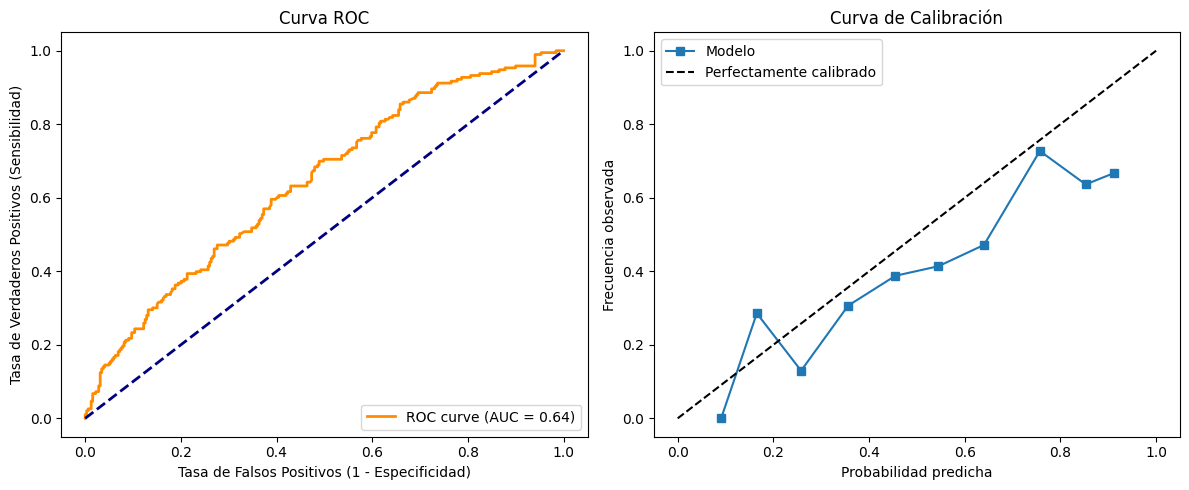

In [149]:
# Cargar el modelo entrenado
modelo = random_search.best_estimator_

# Obtener probabilidades predichas para la clase positiva (LRA=1)
y_proba = modelo.predict_proba(X_test)[:, 1]

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")

# 3. Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

plt.subplot(1,2,2)
plt.plot(prob_pred, prob_true, "s-", label="Modelo")
plt.plot([0, 1], [0, 1], "k--", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curva de Calibración")
plt.legend()

plt.tight_layout()
plt.show()